# Import Module

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
#from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Settings

### Variables

In [2]:
variables = ['tas']
variable = 'tas'
TITLE = 'Surface Temperature'
ylabel = '$E_{tas}$ ($K$)'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/PPE/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/PPE/CNRM-CM6-1_PPE/'
path_files='/data/home/globc/peatier/PPE/CNRMppe/PPE/ENSEMBLE2/files/'

### List of members

In [4]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# Functions

In [5]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

# Get data : obs, PPE, p1

In [6]:
path_observation = '/data/scratch/globc/peatier/obs/BEST/'
filename = 'Land_and_Ocean_LatLong1_regrid_1979-1981.nc'

In [7]:
# POUR LES OBSERVATIONS BEST

path = path_observation

file =  xr.open_mfdataset(path+filename,combine='by_coords')
clim = file['climatology'].to_dataframe()#.drop(columns='month_number')
clim = pd.concat([clim, clim, clim]).reset_index('month_number')

df_obs=file['temperature'].to_dataframe().reset_index('time')
df_obs['temperature'] = df_obs['temperature']
df_obs['clim'] = clim['climatology']
df_obs['ta'] = df_obs['temperature']+df_obs['clim']+273.15
variable_obs = 'ta'
df_obs

time  temperature       clim          ta
lat        lon                                                  
-88.927735 0.00000    1979.0     0.768801 -25.193111  248.725677
           1.40625    1979.0     0.769734 -25.215549  248.704178
           2.81250    1979.0     0.770550 -25.236740  248.683807
           4.21875    1979.0     0.771259 -25.256731  248.664520
           5.62500    1979.0     0.771860 -25.276089  248.645767
...                      ...          ...        ...         ...
 88.927735 352.96875  1981.0     0.004460 -30.711264  242.443192
           354.37500  1981.0    -0.004911 -30.734428  242.410660
           355.78125  1981.0    -0.016334 -30.728228  242.405426
           357.18750  1981.0    -0.024906 -30.703251  242.421844
           358.59375  1981.0    -0.041427 -30.653141  242.455429

[1179648 rows x 4 columns]

In [8]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:      (lat: 128, lon: 256)
Coordinates:
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    time         (lat, lon) float64 1.98e+03 1.98e+03 ... 1.98e+03 1.98e+03
    temperature  (lat, lon) float32 0.1753 0.1755 0.1757 ... -0.158 -0.162
    clim         (lat, lon) float32 -46.88 -46.92 -46.96 ... -19.79 -19.78
    ta           (lat, lon) float32 226.4 226.4 226.4 ... 253.2 253.2 253.2

In [9]:
# Default simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_tas_xarr(path, filename, variables)

In [10]:
# PPE amip simulations 
filename='*_amip_*.nc'

N=len(nb_p_list)
amip={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_tas_xarr(path, filename, variables)
    i=i+1

p311
p312
p314
p316
p317
p319
p320
p321
p322
p324
p325
p326
p329
p330
p331
p332
p335
p336
p337
p338
p340
p341
p343
p344
p346
p347
p348
p349
p350
p353
p355
p357
p359
p360
p361
p363
p365
p367
p368
p369
p372
p373
p374
p375
p376
p378
p381
p382
p384
p386
p388
p389
p391
p392
p393
p394
p395
p396
p398
p399
p400
p404
p406
p407
p409
p410
p411
p412
p414
p416
p413
p419
p424
p426
p428
p421
p423
p425
p427
p429
p430
p436
p438
p431
p433
p442
p446
p443
p445
p447
p452
p454
p456
p458
p457
p459
p460
p465
p467
p469
p470
p471


In [11]:
amip['p1'] = p1_amip

In [12]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    amip_list[i+1] = tmp
    i+=1

In [13]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])

In [14]:
## --Get weights : 
lats = matrix['lat'].values

wgts = np.cos(np.deg2rad(lats))
W_eof_2D = sqrt(wgts)[:,np.newaxis] ## --Wqts before EOF analysis - 2D (lat x lon)
W_eof_3D = sqrt(wgts)[np.newaxis,:,np.newaxis] ## --Wqts before EOF analysis - 3D (time x lat x lon)

S = wgts.sum()*256 ## --Sum of wgts over the whole grid
wgts_sum = wgts/S
W_rmse_2D = wgts_sum[:,np.newaxis] ## -- Wgts before RMSE, divided by sum of wgts - 2D (lat x lon)

In [15]:
# Compute anomalies by removing the time-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean
#anom

In [16]:
anom_w = (anom*W_eof_3D)
#anom_w

# Bootstrap

In [17]:
def MultiLinReg(X_train, pc_train, EOF_nb, x_pred, variable) :
    param_names = np.load(file="/data/home/globc/peatier/PPE/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")    

    y_train = pc_train[:,EOF_nb-1]
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(x_pred)
    
    return y_pred

In [18]:
def emulator_eval_EOF_modes(X_train, X_test, y_train, y_test) : 

    # Create an EOF solver to do the EOF analysis. 
    solver = Eof(y_train, center=False, weights=None)
    pc_train = solver.pcs(npcs=102, pcscaling=1)

    # Prediction and skill evaluation : loop over the 91 modes
    pc_test = solver.projectField(y_test, neofs=102, weighted=False, eofscaling=1)
    x_pred_IS = X_train
    x_pred_OS = X_test
    r_corr_list_IS = []
    r_corr_list_OS = []
    for EOF_nb in range(1,len(pc_train), 1) :
        y_pred_OS = MultiLinReg(X_train, pc_train, EOF_nb, x_pred_OS, variable)
        pc_test_tmp = pc_test[:,EOF_nb-1]
        df_OS = pd.DataFrame(y_pred_OS, columns=['pred'])
        df_OS['true'] = pc_test_tmp
        r_corr_OS = np.corrcoef(df_OS['pred'], df_OS['true'])
        r_corr_list_OS.append(r_corr_OS[0,1])
    
        y_pred_IS = MultiLinReg(X_train, pc_train, EOF_nb, x_pred_IS, variable)
        df_IS = pd.DataFrame(y_pred_IS, columns=['pred'])
        pc_train_tmp = pc_train[:,EOF_nb-1]
        df_IS['true'] = pc_train_tmp
        r_corr_IS = np.corrcoef(df_IS['pred'], df_IS['true'])
        r_corr_list_IS.append(r_corr_IS[0,1])
    
    return r_corr_list_OS, r_corr_list_IS

In [19]:
from sklearn.model_selection import train_test_split
EOF_nb = 1
X = np.load(file="/data/home/globc/peatier/PPE/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = anom_w[1:]

df_fig = pd.DataFrame(range(1, 91, 1), columns=['mode'])
for cpt in range(1,11,1) :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    r_corr_list_OS, r_corr_list_IS = emulator_eval_EOF_modes(X_train, X_test, y_train, y_test)
    df_fig['r_OS_'+str(cpt)] = r_corr_list_OS
    df_fig['r_IS_'+str(cpt)] = r_corr_list_IS

df_fig

,mode,r_OS_1,r_IS_1,r_OS_2,r_IS_2,r_OS_3,r_IS_3,r_OS_4,r_IS_4,r_OS_5,...,r_OS_6,r_IS_6,r_OS_7,r_IS_7,r_OS_8,r_IS_8,r_OS_9,r_IS_9,r_OS_10,r_IS_10
0,1,0.863153,0.954332,0.679649,0.956408,0.888201,0.950340,0.934283,0.947521,0.833164,...,0.853156,0.953134,0.885642,0.954206,0.901178,0.953727,0.944301,0.944809,0.798583,0.954362
1,2,0.874818,0.949805,0.938976,0.945137,0.940255,0.947059,0.585069,0.959592,0.899418,...,0.889997,0.947690,0.923902,0.939966,0.841983,0.954587,0.304353,0.950888,0.903855,0.945452
2,3,0.810316,0.895416,0.692001,0.909646,0.946013,0.867926,0.849279,0.896331,0.843615,...,0.942440,0.892273,0.736180,0.915004,0.666015,0.900479,0.871609,0.891386,0.638833,0.918095
3,4,0.576855,0.797887,0.496958,0.797066,0.720864,0.837055,0.471443,0.823425,0.710740,...,0.827537,0.815479,0.526479,0.831758,0.619969,0.841211,0.323075,0.845920,0.888239,0.816510
4,5,0.851516,0.914948,0.832489,0.911270,0.856979,0.918968,0.652152,0.937521,0.725938,...,0.791287,0.912798,0.811011,0.908396,0.891879,0.903542,0.749216,0.920183,0.897721,0.918396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,-0.100335,0.340057,0.247066,0.467741,0.235596,0.414626,0.320226,0.427680,-0.576501,...,-0.144962,0.456376,0.170312,0.401237,0.038796,0.402593,0.177884,0.368910,-0.030189,0.372659
86,87,-0.656773,0.517237,-0.062117,0.395604,-0.019778,0.418122,-0.130833,0.324353,-0.296127,...,0.181725,0.507109,-0.053289,0.523450,0.513796,0.393106,0.095730,0.530223,0.260928,0.497713
87,88,0.068225,0.474890,0.049443,0.490296,0.250528,0.481249,0.351394,0.429263,-0.036546,...,-0.181660,0.304486,0.355755,0.395822,-0.704688,0.459623,-0.193471,0.418330,0.672131,0.515524
88,89,-0.120786,0.393855,0.478390,0.382133,-0.185817,0.526282,-0.277900,0.494762,0.080804,...,-0.081063,0.421553,0.193633,0.512187,-0.001441,0.534092,0.440256,0.524327,0.075861,0.496091


In [20]:
df_OS = pd.DataFrame(df_fig['r_OS_1'], columns=['r1'])
df_IS = pd.DataFrame(df_fig['r_IS_1'], columns=['r1'])

for j in range(2,11,1) :
    df_OS['r'+str(j)] = df_fig['r_OS_'+str(j)]
    df_IS['r'+str(j)] = df_fig['r_IS_'+str(j)]

r_OS_mean = df_OS.mean(axis = 1)
r_OS_std = df_OS.std(axis = 1)
df_fig['r_OS_mean'] = r_OS_mean
df_fig['r_OS_std'] = r_OS_std

r_IS_mean = df_IS.mean(axis = 1)
r_IS_std = df_IS.std(axis = 1)
df_fig['r_IS_mean'] = r_IS_mean
df_fig['r_IS_std'] = r_IS_std

df_fig['mode'] = range(0, 90, 1)
df_fig

,mode,r_OS_1,r_IS_1,r_OS_2,r_IS_2,r_OS_3,r_IS_3,r_OS_4,r_IS_4,r_OS_5,...,r_OS_8,r_IS_8,r_OS_9,r_IS_9,r_OS_10,r_IS_10,r_OS_mean,r_OS_std,r_IS_mean,r_IS_std
0,0,0.863153,0.954332,0.679649,0.956408,0.888201,0.950340,0.934283,0.947521,0.833164,...,0.901178,0.953727,0.944301,0.944809,0.798583,0.954362,0.857573,0.081229,0.951720,0.003692
1,1,0.874818,0.949805,0.938976,0.945137,0.940255,0.947059,0.585069,0.959592,0.899418,...,0.841983,0.954587,0.304353,0.950888,0.903855,0.945452,0.803090,0.216981,0.949002,0.005748
2,2,0.810316,0.895416,0.692001,0.909646,0.946013,0.867926,0.849279,0.896331,0.843615,...,0.666015,0.900479,0.871609,0.891386,0.638833,0.918095,0.798443,0.117638,0.899575,0.015189
3,3,0.576855,0.797887,0.496958,0.797066,0.720864,0.837055,0.471443,0.823425,0.710740,...,0.619969,0.841211,0.323075,0.845920,0.888239,0.816510,0.620589,0.182875,0.830676,0.020516
4,4,0.851516,0.914948,0.832489,0.911270,0.856979,0.918968,0.652152,0.937521,0.725938,...,0.891879,0.903542,0.749216,0.920183,0.897721,0.918396,0.800963,0.080936,0.914256,0.011542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,-0.100335,0.340057,0.247066,0.467741,0.235596,0.414626,0.320226,0.427680,-0.576501,...,0.038796,0.402593,0.177884,0.368910,-0.030189,0.372659,0.048692,0.277080,0.419722,0.037553
86,86,-0.656773,0.517237,-0.062117,0.395604,-0.019778,0.418122,-0.130833,0.324353,-0.296127,...,0.513796,0.393106,0.095730,0.530223,0.260928,0.497713,0.054448,0.239655,0.441162,0.074546
87,87,0.068225,0.474890,0.049443,0.490296,0.250528,0.481249,0.351394,0.429263,-0.036546,...,-0.704688,0.459623,-0.193471,0.418330,0.672131,0.515524,0.062543,0.403137,0.429557,0.066089
88,88,-0.120786,0.393855,0.478390,0.382133,-0.185817,0.526282,-0.277900,0.494762,0.080804,...,-0.001441,0.534092,0.440256,0.524327,0.075861,0.496091,0.080303,0.258058,0.480395,0.054578


In [21]:
cumul_corr_mean = []
cumul_corr_std = []
for i in range(0, len(df_fig), 1) :
    tmp = df_fig[0:i]['r_OS_mean'].mean()
    cumul_corr_mean.append(tmp)
    
    tmp = df_fig[0:i]['r_OS_std'].mean()
    cumul_corr_std.append(tmp)
    
df_fig['cumul_corr_mean'] = cumul_corr_mean
df_fig['cumul_corr_std'] = cumul_corr_std

In [22]:
## Test moyenne de corrélation pour 5, 10, 15, 20, 25, 50, 75 
mean_OS_5 = df_fig[0:5]['r_OS_mean'].mean()
mean_OS_10 = df_fig[0:10]['r_OS_mean'].mean()
mean_OS_15 = df_fig[0:15]['r_OS_mean'].mean()
mean_OS_20 = df_fig[0:20]['r_OS_mean'].mean()
mean_OS_25 = df_fig[0:25]['r_OS_mean'].mean()
mean_OS_50 = df_fig[0:50]['r_OS_mean'].mean()

# Download explained variance

In [28]:
path_files = '/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'

In [37]:
path = path_files+'nc/'
filename = 'Variance_explained_EOF_modes.nc'
var_modes = xr.open_mfdataset(path+filename)

In [84]:
df_var_fig = pd.DataFrame()
variables = ['tas', 'pr', 'psl', 'SW', 'LW']
var_cumul = {}
for var in variables :
    print(var)
    var_cumul[var] = []
    tmp=0
    var_cumul[var].append(None)
    for i in range(0,103,1) :
        #print(i)
        tmp = tmp + float(var_modes[var][i])
        var_cumul[var].append(tmp*100)
    df_var_fig[var] = var_cumul[var]
df_var_fig

tas
pr
psl
SW
LW


,tas,pr,psl,SW,LW
0,NaN,NaN,NaN,NaN,NaN
1,59.029308,29.646516,72.034468,66.049043,63.593922
2,73.345366,48.614942,81.257812,77.410143,73.411395
3,79.209360,57.126450,84.483043,85.441999,81.780944
4,82.251061,64.241320,86.778733,88.117941,85.055158
...,...,...,...,...,...
99,99.959417,99.830643,99.990726,99.954439,99.960182
100,99.973465,99.890838,99.994036,99.970100,99.973897
101,99.987355,99.947495,99.997067,99.985412,99.987467
102,100.000000,100.000000,100.000000,100.000000,100.000000


# Figure

In [94]:
trunc=17
var = 'tas'
var_trunc = 5

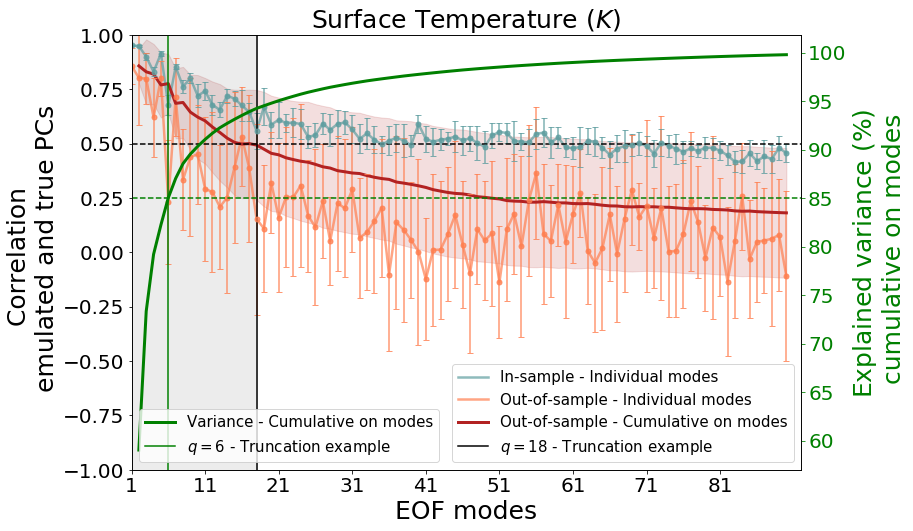

In [96]:
plt.figure(figsize=(12, 8))
    

ax = plt.gca()

df_fig.plot(kind='line', y='r_IS_mean', color = 'cadetblue', alpha=0.7, linewidth=2.5, ax=ax)
df_fig.plot(kind='line', y='r_OS_mean', color = 'coral', alpha=0.7, linewidth=2.5, ax=ax)

df_fig.plot(kind='line', y='cumul_corr_mean', color = 'firebrick', alpha=1, linewidth=3, ax=ax)
xfit = df_fig['mode']
yfit = df_fig['cumul_corr_mean']
dyfit = df_fig['cumul_corr_std']
plt.fill_between(xfit, yfit - dyfit, yfit + dyfit, color='firebrick', alpha=0.15)

plt.errorbar(x=df_fig['mode'], y=df_fig['r_IS_mean'], yerr=df_fig['r_IS_std'], xerr=None, 
             linestyle='none', 
             marker='.', markersize=10,
             capsize=3,
             alpha=0.8,
             ecolor='cadetblue', 
             color= 'cadetblue')

plt.errorbar(x=df_fig['mode'], y=df_fig['r_OS_mean'], yerr=df_fig['r_OS_std'], xerr=None, 
             linestyle='none', 
             marker='.', markersize=10,
             capsize=3,
             alpha=0.8,
             ecolor='coral', 
             color= 'coral')

ax.axhline(y=0.5, color='black', linestyle='dashed', label = '_nolegend_')
#plt.axhline(y=0.25, color='gray', linestyle='dashed', label = '_nolegend_')
#plt.axhline(y=0.75, color='gray', linestyle='dashed', label = '_nolegend_')
plt.axvspan(0, trunc, color='grey', alpha=0.15)

ax.axvline(x=trunc, color='black', linestyle='solid')

#ax.axhline(0, color='k', alpha=0.5)
ax.set_ylim(-1, 1)
ax.set_xlabel('EOF modes', size = 25)
ax.set_ylabel('Correlation \n emulated and true PCs', size = 25)
ax.set_title('Surface Temperature ($K$)', fontsize=25)
#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
#ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
ax.set_xticks(range(0, 90, 10))
ax.set_xticklabels(range(1, 91, 10))

plt.xticks(rotation=0)

### --------- ADD EXTRA .........
ax2 = ax.twinx()
df_var_fig[0:-14].plot(kind='line', style = '-', y=var, color = 'green', linewidth=3, ax=ax2)
ax2.set_ylabel('Explained variance ($\%$) \n cumulative on modes', size = 25, color = "green")
ax2.tick_params(axis='y', which='major', labelsize=20, colors='green')
ax2.axhline(y=85, color='green', linestyle='dashed', label = '_nolegend_')
ax2.axvline(x=var_trunc, color='green', linestyle='solid')
ax.legend(legend, fontsize=15) #bbox_to_anchor=(1.05, 1)
ax2.legend(['Variance - Cumulative on modes', '$q=$'+str(var_trunc+1)+' - Truncation example'], 
           loc = 'lower left', fontsize=15)
plt.xlim(0,91)
### --------- --------- .........

# Legend .................

legend = [ 'In-sample - Individual modes', 'Out-of-sample - Individual modes', 
          'Out-of-sample - Cumulative on modes', '$q=$'+str(trunc+1)+' - Truncation example']
#ax.get_legend().remove()

# Grid .................
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/PPE/figures/Skill_emul_"+variable+".png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()